In [223]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import os
import sys
import h5py
os.environ["GDAL_DATA"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/gdal' # need to specify to make gdal work
os.environ["PROJ_LIB"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/proj' # need to specify to make pyproj work
os.environ["PROJ_DATA"] = '/Users/ccroberts/opt/anaconda3/envs/fresh/share/proj' # need to specify to make pyproj work

import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import cm 
import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
import shapely
from shapely import box, LineString, Point
from ipyleaflet import Map, basemaps, Polygon, Polyline, GeoData, LayersControl
from datetime import datetime
from datetime import timedelta
from datetime import timezone
from dateutil.relativedelta import relativedelta
from rasterio import warp
from rasterio.crs import CRS
import shutil
import time
import traceback

import pyTMD

if 'cmcrameri' not in sys.modules:
    ! pip3 install cmcrameri >/dev/null
if 'contextily' not in sys.modules:
    ! pip3 install contextily >/dev/null
import cmcrameri.cm as cmc
import contextily as cx

'''
try:
    from ed.edcreds import getedcreds
except:
    print('No earthdata credentials found.')
    print('To set up, rename the folder "ed_example" to "ed".')
    print('Then, add your earthdata credentials to "ed/edcreds.py".')
'''

from utils.nsidc import download_is2
#from utils.S2 import plotS2cloudfree, add_inset, convert_time_to_string
from utils.utilities import is2dt2str

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Specify the base parameters

We do this using the package `contextily`, which provides basemaps for plotting in matplotlib. Here we use ESRI's WordImagery basemap. 

In [2]:
'''

Terrible process
you have to export polygons as 4326 from QGIS
Then you can force import them as 4326 and convert to 3031

because NSIDC needs 4326 polygons
'''

'\n\nTerrible process\nyou have to export polygons as 4326 from QGIS\nThen you can force import them as 4326 and convert to 3031\n\nbecause NSIDC needs 4326 polygons\n'

In [264]:
basin = 'Cp-D'
region='chugunov'
track = 1352 #totten
track = 727 #test
track=537 #chugunov

In [265]:
#shape for the subsetting
shape = f'shapes/{basin}_{region}.shp'
#shape for the outline of the pinning point
pts = f'shapes/{basin}_{region}_pp.shp'
plot_dir = 'plots'
crs_antarctica = 'EPSG:3031'
crs_latlon = 'EPSG:4326'
short_name = 'ATL11'
output_dir = f'data/is2/{short_name}_{shape[:shape.rfind('.')].split('/')[-1]}'
gdf = gpd.read_file(shape).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)
pp_gdf = gpd.read_file(pts).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)

<Axes: >

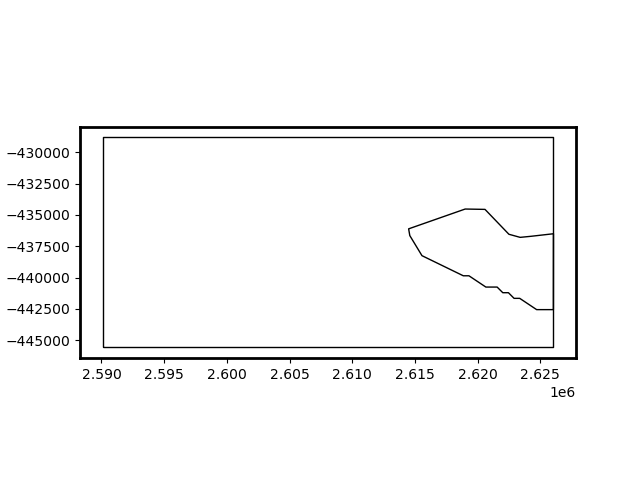

In [266]:
fig1, ax1 = plt.subplots()
pp_gdf.plot(ax=ax1, color='None', edgecolor='black')
gdf.plot(ax=ax1, color='None', edgecolor='black')

# define a bunch of functions

In [269]:
def download_data():
    uid,pw,eml = getedcreds()
    output_dir = f'data/is2/{short_name}_{shape[:shape.rfind('.')].split('/')[-1]}'
    download_is2(short_name='ATL11', uid=uid, pwd=pw, email=eml, output_dir=output_dir, shape=shape, shape_subset=shape)
    print('saved files to %s' % output_dir)
    return output_dir

def get_file_info():
    search_for = '%s_' % short_name
    search_in = output_dir + '/'
    filelist = [search_in+f for f in os.listdir(search_in) \
                if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
    filelist.sort()
    print('There are %i files.' % len(filelist))
    
    dirdict = dict([(x,'ascending') for x in [1,2,3,12,13,14]] + \
                   [(x,'descending') for x in [5,6,7,8,9,10]] + \
                   [(x,'turning') for x in [4,11]])
    df_files = pd.DataFrame({'filename': filelist})
    df_files['granule_id'] = df_files.apply(lambda x: x.filename[x.filename.rfind(search_for):], axis=1)
    df_files['tides_filename'] = df_files.apply(lambda x: f'{output_dir}/tides/ATL11_CATS2008-v2023_TIDES_{x.granule_id[6:]}', axis=1)
    df_files['track'] = df_files.apply(lambda x: int(x.granule_id[6:10]), axis=1)
    df_files['region'] = df_files.apply(lambda x: int(x.granule_id[10:12]), axis=1)
    df_files['direction'] = df_files.apply(lambda x: dirdict[x.region], axis=1)
    df_files['cycles'] = df_files.apply(lambda x: '%s-%s' % (x.granule_id[13:15],x.granule_id[15:17]), axis=1)
    df_files['version'] = df_files.apply(lambda x: int(x.granule_id[18:21]), axis=1)
    df_files['release'] = df_files.apply(lambda x: int(x.granule_id[22:24]), axis=1)
    return df_files

def getedcreds():

    # change your credentials here, do not push them to github! 
    uid = 'ccroberts'
    pwd = 'Stratele1.'
    email = 'ccroberts@ucsd.edu'

    # to print a message if they haven't been changed
    if uid == '<your_nasa_earthdata_user_id>':
        print('\n WARNING: YOU NEED TO SET UP YOUR NASA EARTHDATA CREDENTIALS TO DOWNLOAD ICESAT-2 DATA!\n')
        print('  update the info in ed/edcreds.py :\n')
        print("  def getedcreds():")
        print("    # change your credentials here, do not push them to github!")
        print("    uid = '<your_nasa_earthdata_user_id>'")
        print("    pwd = '<your_nasa_earthdata_password>'")
        print("    email = '<your_nasa_earthdata_account_email>'")
        return None
    else:
        return uid, pwd, email

def is2dt2str(lake_mean_delta_time):
    lake_mean_delta_time = np.mean(lake_mean_delta_time)
    if np.isnan(lake_mean_delta_time) | (lake_mean_delta_time == np.inf):
        return np.nan
    else:
        ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc)
        ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
        lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
        lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
        time_format_out = '%Y-%m-%dT%H:%M:%SZ'
        is2time = datetime.strftime(lake_mean_datetime, time_format_out)
        return is2time

def read_atl11(filename):
    with h5py.File(filename, 'r') as f:
        datadict = {}
        pts = [x for x in f.keys() if 'pt' in x]
        for pt in pts:
            vars_data = ['delta_time', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'quality_summary']
            vars_coords = ['cycle_number','latitude', 'longitude','ref_pt', 'ref_surf/geoid_h']
            ds = xr.Dataset({v: (['x_atc', 'cycle_number'], f[pt][v][()]) for v in vars_data}, coords={v:f[pt][v][()] for v in vars_coords})
            ds = ds.rename({'ref_surf/geoid_h': 'geoid'})
            ds.coords["x_atc"] = np.arange(len(f[pt]['latitude'][()])) * 60
            h_arr = np.array(ds.h_corr) # go to numpy for 2-d boolean indexing
            h_arr[ds.quality_summary>0] = np.nan
            h_arr[h_arr>1e5] = np.nan
            ds['h_corr'] = (ds.h_corr.dims, h_arr)
            datadict[pt] = ds
    return datadict

def get_info_df_atl11(datadict):
    dfhs = {}
    for i,k in enumerate(datadict.keys()):
        ds = datadict[k]
        std_select = ds.h_corr.std(dim='cycle_number') < 1.
        h_diff = ds.h_corr.where(std_select) - ds.h_corr.mean(dim='cycle_number')
        dfh = pd.DataFrame({'h_diff_mean': h_diff.mean(dim='x_atc')}, index=ds.cycle_number)
        dfh['perc_nan'] = xr.apply_ufunc(lambda x: np.sum(np.isnan(x))/len(x), ds.h_corr, input_core_dims=[["x_atc"]], dask='allowed', vectorize=True)
        dfh['date_time_utc'] = [is2dt2str(mean_dt) for mean_dt in np.array(ds.delta_time.where(ds.delta_time < 1e10).mean(dim='x_atc'))]
        dfh['date_time_utc'] = pd.to_datetime(dfh['date_time_utc'], format="%Y-%m-%dT%H:%M:%SZ").astype('datetime64[us]')
        dfh['date'] = dfh.apply(lambda x: str(x.date_time_utc)[:10], axis=1)
        dfh = dfh[(dfh.perc_nan < .1) & (~np.isnan(dfh.h_diff_mean))]
        dfh = dfh.sort_values(by='h_diff_mean')
        dfh['h_rank'] = np.arange(len(dfh))
        dfh['cycle_number'] = dfh.index
        dfh = dfh.sort_values(by='cycle_number')
        dfhs[k] = dfh
    dfs_all = pd.concat(dfhs)
    dfh_all = dfs_all.groupby('cycle_number')[['h_diff_mean', 'perc_nan']].mean()
    dfh_all['date'] = dfs_all.groupby('cycle_number')['date'].first()
    dfh_all['date_time_utc'] = dfs_all.groupby('cycle_number')['date_time_utc'].first()
    dfh_all = dfh_all.reset_index()
    
    dfh_all = dfh_all.sort_values(by='h_diff_mean')
    dfh_all['h_rank'] = np.arange(len(dfh_all))
    dfh_all['color_mean'] = [tuple(row[:3]) for row in cmc.vik(np.linspace(0.15,0.85,len(dfh_all))).tolist()]
    dfh_all = dfh_all.sort_values(by='date')
    dfh_all['color_chrono'] = [tuple(row[:3]) for row in plt.cm.GnBu(np.linspace(0.15,0.85,len(dfh_all))).tolist()]
    dfh_all = dfh_all.sort_values(by='cycle_number')
    return dfh_all

def get_ground_tracks(datadict):
    crs_latlon = 'EPSG:4326'
    gts = []
    for k in datadict.keys():
        ds = datadict[k]
        gdf_gt = gpd.GeoDataFrame(geometry=gpd.points_from_xy(ds.longitude, ds.latitude), crs=crs_latlon)
        gdf_gt['pt'] = k
        gts.append(gdf_gt)
    gdf_gts = gpd.GeoDataFrame(geometry=pd.concat(gts).groupby(['pt'])[['geometry']].apply(lambda x: LineString(x.geometry.tolist()))
                              ).reset_index().set_crs(crs_latlon)
    colordict = {'col0': 'darkblue', 'col1': 'rebeccapurple', 'col2': 'palevioletred', 'col3': 'thistle'}
    gdf_gts['plotcolor'] = gdf_gts.apply(lambda x: colordict['col%s' % (int(x.pt[2])-1)], axis=1)
    return gdf_gts

def get_grounded_distances(gt_geom, pp_poly):
    # inputs: shapely shapes
    
    # Find where gt is grounded and return limits of each segment
    # to serve as limits for ax.axvspan()
    
    # Get list of line strings over pinning points
    try: pp_linestring = list(shapely.get_parts(gt_geom.intersection(pp_poly)))
    except: 
        print('EXCEPTION: Check that inputs are shapely shapes')
        return
    # grab the two alongtrack distance points, if there are none return empty
    try: pp_dist = [(gt_geom.line_locate_point(Point(l.coords[0])), gt_geom.line_locate_point(Point(l.coords[-1]))) for l in pp_linestring]
    except: pp_dist = []
    return pp_dist

def set_axis_color(ax, axcolor):
    ax.spines['bottom'].set_color(axcolor)
    ax.spines['top'].set_color(axcolor) 
    ax.spines['right'].set_color(axcolor)
    ax.spines['left'].set_color(axcolor)
    ax.tick_params(axis='x', colors=axcolor)
    ax.tick_params(axis='y', colors=axcolor)
    ax.yaxis.label.set_color(axcolor)
    ax.xaxis.label.set_color(axcolor)
    ax.title.set_color(axcolor)

def make_plot(track, kind='abs', color_type='chrono', imagery_resolution_adjust=1, save=True):
    # get the data
    filename = df_files[df_files.track == track].filename.iloc[0]
    tides_filename = df_files[df_files.track == track].tides_filename.iloc[0]
    datadict = read_atl11(filename)
    tidedict = read_atl11_tides(tides_filename)
    gdf_gts = get_ground_tracks(datadict).to_crs(crs_antarctica)
    #pp_gdf = pp_gdf
    dfh_all = get_info_df_atl11(datadict)
    
    # figure setup
    imagery_aspect = 1.3
    
    # make figure and axes
    fig = plt.figure(figsize=[12,6], dpi=80)
    gs = fig.add_gridspec(3, 10)
    axs = [fig.add_subplot(gs[:, :4])]
    for i in range(3):
        axs.append(fig.add_subplot(gs[i, 4:9]))
    axs.append(fig.add_subplot(gs[:, 9]))
    boxprops = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='none', pad=0.2)
    
    # plot the basemap and ground track
    # We do this using the package `contextily`, which provides basemaps for plotting in matplotlib. 
    # Here we use ESRI's WordImagery basemap. 
    ax = axs[0]
    hdls = []
    hdl_end = gdf.exterior.plot(ax=ax, color='k', label='study region')
    buffer = 0.1 * np.max([gdf.total_bounds[i+2] - gdf.total_bounds[i] for i in [0,1]])
    bbox = np.array(box(*gdf.total_bounds).buffer(buffer).bounds)
    xrng = bbox[2] - bbox[0]
    yrng = xrng*imagery_aspect
    ymid = np.mean(bbox[[1,3]])
    ax.set_xlim(bbox[[0,2]])
    ax.set_ylim([ymid - yrng/2, ymid + yrng/2])
    cx.add_basemap(ax=ax, crs=crs_antarctica, source=cx.providers.Esri.WorldImagery, 
                   zoom_adjust=imagery_resolution_adjust, attribution='imagery ©ESRI (WorldImagery)', attribution_size=7)
    
    pp_gdf.plot(ax=ax, color='None', edgecolor='gray')
    
    for i in range(len(gdf_gts)):
        row = gdf_gts.iloc[i]
        coords = shapely.get_coordinates(row.geometry)
        hdl, = ax.plot(coords[:,0], coords[:,1], color=row.plotcolor, lw=1, label='RPT%s' % row.pt[-1])
        arr_xlen = coords[-1,0] - coords[0,0]
        arr_ylen = coords[-1,1] - coords[0,1]
        arrow_width = 100
        arrow_gt = ax.arrow(coords[0,0], coords[0,1], arr_xlen, arr_ylen, length_includes_head=True, color=row.plotcolor,
                            width=arrow_width, head_width=8*arrow_width, head_length=15*arrow_width, lw=1)
        hdls.append(hdl)
    
    hdls.append(hdl_end)
    ax.axis('off')
    ax.legend(handles=hdls, loc='lower right', fontsize=11)
    ax.text(0.5, 0.95, 'ICESat-2 track %s' % track, transform=ax.transAxes, ha='center', va='center', fontsize=15, fontweight='bold', bbox=boxprops)
    
    
    
    # plot the icesat-2 repeat track data
    hdls = [np.nan]*len(dfh_all)
    for i,k in enumerate(datadict.keys()):
        ds = datadict[k]
        dst = tidedict[k]
        #override to take values from first dataset in merge
        ds_merge = xr.merge([ds, dst], join='inner', compat='override')
        ax = axs[i+1]
        
        #grey out the grounded regions
        pp_dist = get_grounded_distances(gdf_gts.geometry[i], pp_gdf.geometry[0])
        for pp in pp_dist: ax.axvspan(pp[0]/1000, pp[1]/1000, color='lightgray')
        h_mean = ds.h_corr.mean(dim='cycle_number')
        geoid = np.mean(ds.geoid)
        
        ax.plot([0, ds.x_atc.max()/1000], [0]*2, 'k--')
        
        for j, c in enumerate(dfh_all.cycle_number):
            row_all = dfh_all.iloc[j]
            is_minmax = ((row_all.h_rank==0) | (row_all.h_rank==np.nanmax(dfh_all.h_rank)))
            #uncommented to support chronological coloring
            lw = 1.5 #if is_minmax else 0.7
            alpha = 1 #if is_minmax else 0.7
            if kind=='abs': 
                tides = np.array(pd.Series(ds_merge.tide_cats.sel(cycle_number=c)))
                h_plot = np.array(pd.Series(ds.h_corr.sel(cycle_number=c)-geoid-tides))#.rolling(window=10, 
            #         center=True, min_periods=1, win_type='gaussian').mean(std=3))
            elif kind=='ano': h_plot = np.array(pd.Series(ds.h_corr.sel(cycle_number=c)-h_mean))#.rolling(window=10, 
            #         center=True, min_periods=1, win_type='gaussian').mean(std=3))
            elif kind=='tides': h_plot =- np.array(pd.Series(ds_merge.tide_cats.sel(cycle_number=c)))
            color = row_all[f'color_{color_type}']
            hdls[j], = ax.plot(ds.x_atc/1000, h_plot, color=color, lw=lw, alpha=alpha, label='cycle %d\n%s' % (c, row_all.date))
        ax.set_xlim([0, ds.x_atc.max()/1000])
        if kind=='ano' or kind=='tides': ax.set_ylim([-3, 3])
        elif kind=='abs': ax.set_ylim([-2, 170])
        ax.set_ylabel(r'elevation (m)')
        thiscolor = gdf_gts[gdf_gts.pt==k].plotcolor.iloc[0]
        set_axis_color(ax=ax, axcolor=thiscolor)
        if i==(len(datadict.keys())-1):
            ax.set_xlabel('along-track distance (km)', color='k')
        ax.text(0.5, 0.97, 'RPT%s' % k[-1], transform=ax.transAxes, ha='center', va='top', fontsize=13, fontweight='bold', color=thiscolor, bbox=boxprops)
    
    # remove extra axes if no data
    for i in np.arange(len(datadict.keys()),3):
        axs[i+1].axis('off')
    
    # legend on right
    ax = axs[-1]
    ax.axis('off')
    ax.legend(handles=hdls, loc='center', fontsize=8)
    fig.tight_layout(h_pad=0.3, w_pad=0.3)
    
    if not os.path.exists(plot_dir): os.makedirs(plot_dir)
    plotname = '%s/GZflex_%s_%s_track%04d_%s.jpg' % (plot_dir, shape[:shape.rfind('.')].split('/')[-1], short_name, int(track), kind)
    if save: fig.savefig(plotname, dpi=600)
    plt.close(fig)
    
    return fig

def plot_one(track, rpt, save=False):
    '''
    input:
        track: int
        rpt: int
        save: boolean

    output: 
        fig
    '''
    
    # get the data
    filename = df_files[df_files.track == track].filename.iloc[0]
    tides_filename = df_files[df_files.track == track].tides_filename.iloc[0]
    datadict = read_atl11(filename)
    tidedict = read_atl11_tides(tides_filename)
    gdf_gts = get_ground_tracks(datadict).to_crs(crs_antarctica)
    #pp_gdf = pp_gdf
    dfh_all = get_info_df_atl11(datadict)
    
    # make figure and axes
    fig = plt.figure(figsize=[12,6], dpi=80)
    gs = fig.add_gridspec(2, 5)
    axs = []
    for i in range(2):
        axs.append(fig.add_subplot(gs[i, :4]))
    axs.append(fig.add_subplot(gs[:, 4]))
    boxprops = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='none', pad=0.2)

    # plot the icesat-2 repeat track data
    hdls = [np.nan]*len(dfh_all)
    
    i, k = rpt, f'pt{rpt}'
    ds = datadict[k]
    for l, kind in enumerate(['abs', 'ano']):
        ax = axs[l]
        
        #grey out the grounded regions
        pp_dist = get_grounded_distances(gdf_gts.geometry[i], pp_gdf.geometry[0])
        for pp in pp_dist: ax.axvspan(pp[0]/1000, pp[1]/1000, color='lightgray')
        h_mean = ds.h_corr.mean(dim='cycle_number')
        geoid = np.mean(ds.geoid)
        
        ax.plot([0, ds.x_atc.max()/1000], [0]*2, 'k--')
        
        for j, c in enumerate(dfh_all.cycle_number):
            row_all = dfh_all.iloc[j]
            date = c.date_time_utc
            is_minmax = ((row_all.h_rank==0) | (row_all.h_rank==np.nanmax(dfh_all.h_rank)))
            lw = 1.5 if is_minmax else 0.7
            alpha = 1 if is_minmax else 0.7
            if kind=='abs': h_plot = np.array(pd.Series(ds.h_corr.sel(cycle_number=c)-geoid))#.rolling(window=10, 
            #         center=True, min_periods=1, win_type='gaussian').mean(std=3))
            elif kind=='ano': h_plot = np.array(pd.Series(ds.h_corr.sel(cycle_number=c)-h_mean))#.rolling(window=10, 
            #         center=True, min_periods=1, win_type='gaussian').mean(std=3))
            hdls[j], = ax.plot(ds.x_atc/1000, h_plot, color=row_all.color, lw=lw, alpha=alpha, label='cycle %d\n%s' % (c, row_all.date))
        ax.set_xlim([0, ds.x_atc.max()/1000])
        if kind=='ano': ax.set_ylim([-2, 2])
        elif kind=='abs': ax.set_ylim([-2, 120])
        ax.set_ylabel(r'elevation (m)')
        thiscolor = gdf_gts[gdf_gts.pt==k].plotcolor.iloc[0]
        set_axis_color(ax=ax, axcolor=thiscolor)
        if i==(len(datadict.keys())-1):
            ax.set_xlabel('along-track distance (km)', color='k')
        ax.text(0.5, 0.97, 'RGT %s, RPT%s' % (track, k[-1]), transform=ax.transAxes, ha='center', va='top', fontsize=13, fontweight='bold', color=thiscolor, bbox=boxprops)

    # legend on right
    ax = axs[-1]
    ax.axis('off')
    ax.legend(handles=hdls, loc='center', fontsize=8)
    fig.tight_layout(h_pad=0.3, w_pad=0.3)
    
    if not os.path.exists(plot_dir): os.makedirs(plot_dir)
    plotname = '%s/GZflex_%s_%s_track%04d_pt%s.jpg' % (plot_dir, shape[:shape.rfind('.')].split('/')[-1], short_name, int(track), rpt)
    if save: fig.savefig(plotname, dpi=600)
    plt.close(fig)
    
    return fig

def retry(num_attempts=1, sleep_time=5):
    for i in range(num_attempts): 
        try: 
            download_data()
            print(f'success on attempt {i}')
            return
        except Exception as e:
            if i==num_attempts-1:
                print(f"The following error occurred: {e}")
                traceback.print_exc()
            time.sleep(sleep_time)
    return

def read_atl11_tides(filename):
    with h5py.File(filename, 'r') as f:
        tidedict = {}
        pts = [x for x in f.keys() if 'pt' in x]
        for pt in pts:
            vars_data = ['delta_time', 'cycle_stats/tide_ocean']
            vars_coords = ['cycle_number', 'latitude', 'longitude', 'ref_pt']
            ds = xr.Dataset({v: (['x_atc', 'cycle_number'], f[pt][v][()]) for v in vars_data}, coords={v:f[pt][v][()] for v in vars_coords})
            ds.coords["x_atc"] = np.arange(len(f[pt]['latitude'][()])) * 60
            ds = ds.rename({'cycle_stats/tide_ocean': 'tide_cats'})
            tide_cats = np.array(ds.tide_cats) # go to numpy for 2-d boolean indexing
            #tide_cats[tide_cats>1e5]=0.0
            ds['tide_cats'] = (ds.tide_cats.dims, tide_cats)
            tidedict[pt] = ds
    return tidedict

'''
def get_tides(datadict, dfh_all, path_to_tide_model='../data'):
    x, y, dt = ds.longitude, ds.latitude, dfh_all.sssssssss
    tide_h = pyTMD.compute_tide_corrections(x, y, dt,
    DIRECTORY=path_to_tide_model, correction='ocean',
    MODEL='CATS2008-v2023', EPSG=4326, EPOCH=pd.Timestamp('1970-01-01 00:00:00'),
    TYPE='drift', TIME='datetime',
    METHOD='spline', FILL_VALUE=np.nan)
    #ss_atl06_sr['tide_cats'] = tide_h
    #ss_atl06_sr.h_mean -= ss_atl06_sr.geoid+ss_atl06_sr.tide_earth+ss_atl06_sr.tide_cats
    return x, y, dt
'''

"\ndef get_tides(datadict, dfh_all, path_to_tide_model='../data'):\n    x, y, dt = ds.longitude, ds.latitude, dfh_all.sssssssss\n    tide_h = pyTMD.compute_tide_corrections(x, y, dt,\n    DIRECTORY=path_to_tide_model, correction='ocean',\n    MODEL='CATS2008-v2023', EPSG=4326, EPOCH=pd.Timestamp('1970-01-01 00:00:00'),\n    TYPE='drift', TIME='datetime',\n    METHOD='spline', FILL_VALUE=np.nan)\n    #ss_atl06_sr['tide_cats'] = tide_h\n    #ss_atl06_sr.h_mean -= ss_atl06_sr.geoid+ss_atl06_sr.tide_earth+ss_atl06_sr.tide_cats\n    return x, y, dt\n"

In [271]:
%%time
# comment out after downloading 
#retry(20, 20)
#download_data()

df_files = get_file_info()
df_files

There are 6 files.
CPU times: user 11.3 ms, sys: 2.82 ms, total: 14.1 ms
Wall time: 14 ms


,filename,granule_id,tides_filename,track,region,direction,cycles,version,release
0,data/is2/ATL11_Cp-D_chugunov/processed_ATL11_0...,ATL11_003410_0322_006_07.h5,data/is2/ATL11_Cp-D_chugunov/tides/ATL11_CATS2...,34,10,descending,03-22,6,7
1,data/is2/ATL11_Cp-D_chugunov/processed_ATL11_0...,ATL11_030112_0322_006_07.h5,data/is2/ATL11_Cp-D_chugunov/tides/ATL11_CATS2...,301,12,ascending,03-22,6,7
2,data/is2/ATL11_Cp-D_chugunov/processed_ATL11_0...,ATL11_053710_0322_006_07.h5,data/is2/ATL11_Cp-D_chugunov/tides/ATL11_CATS2...,537,10,descending,03-22,6,7
3,data/is2/ATL11_Cp-D_chugunov/processed_ATL11_0...,ATL11_074312_0322_006_07.h5,data/is2/ATL11_Cp-D_chugunov/tides/ATL11_CATS2...,743,12,ascending,03-22,6,7
4,data/is2/ATL11_Cp-D_chugunov/processed_ATL11_0...,ATL11_097910_0322_006_07.h5,data/is2/ATL11_Cp-D_chugunov/tides/ATL11_CATS2...,979,10,descending,03-22,6,7
5,data/is2/ATL11_Cp-D_chugunov/processed_ATL11_1...,ATL11_118512_0322_006_07.h5,data/is2/ATL11_Cp-D_chugunov/tides/ATL11_CATS2...,1185,12,ascending,03-22,6,7


In [272]:
%%time

#plot track with type ano: anomaly or abs: absolute elevations
fig=make_plot(track, kind='tides', color_type='chrono', imagery_resolution_adjust=2, save=False)

CPU times: user 7.94 s, sys: 1.19 s, total: 9.13 s
Wall time: 34.4 s


/var/folders/_l/6jgyk_ms6jb13hn0khtb7f7m003707/T/ipykernel_98763/3317971099.py:205: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles=hdls, loc='lower right', fontsize=11)


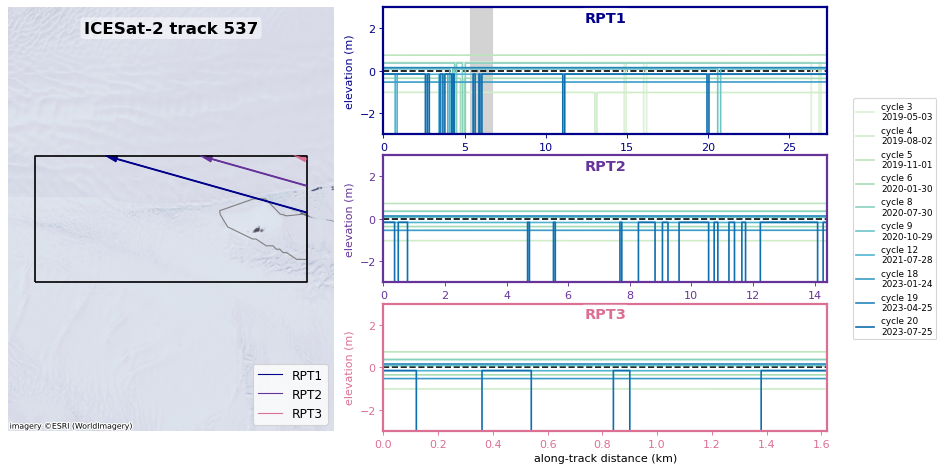

CPU times: user 995 ms, sys: 40.1 ms, total: 1.04 s
Wall time: 1.04 s


In [273]:
%%time
display(fig)

In [ ]:
# Messing with tides

In [238]:
filename = df_files[df_files.track == track].filename.iloc[0]
tides_filename = df_files[df_files.track == track].tides_filename.iloc[0]
datadict = read_atl11(filename)
tidedict = read_atl11_tides(tides_filename)
gdf_gts = get_ground_tracks(datadict).to_crs(crs_antarctica)
#pp_gdf = pp_gdf
dfh_all = get_info_df_atl11(datadict)

ds = datadict['pt1']
dst = tidedict['pt1']

In [258]:
ds

<xarray.Dataset> Size: 122kB
Dimensions:                  (x_atc: 269, cycle_number: 20, latitude: 269,
                              longitude: 269, ref_pt: 269, geoid: 269)
Coordinates:
  * cycle_number             (cycle_number) int8 20B 3 4 5 6 7 ... 19 20 21 22
  * latitude                 (latitude) float64 2kB -67.13 -67.13 ... -66.99
  * longitude                (longitude) float64 2kB 117.7 117.7 ... 117.6 117.6
  * ref_pt                   (ref_pt) int32 1kB 1632606 1632609 ... 1633410
  * geoid                    (geoid) float32 1kB -25.77 -25.77 ... -25.79 -25.79
  * x_atc                    (x_atc) int64 2kB 0 60 120 ... 15960 16020 16080
Data variables:
    delta_time               (x_atc, cycle_number) float64 43kB 1.798e+308 .....
    h_corr                   (x_atc, cycle_number) float32 22kB nan nan ... nan
    h_corr_sigma             (x_atc, cycle_number) float32 22kB 3.403e+38 ......
    h_corr_sigma_systematic  (x_atc, cycle_number) float32 22kB 3.403e+38 ......
    quality_summary          (x_atc, cycle_number) int8 5kB 1 1 1 1 ... 1 1 0 1

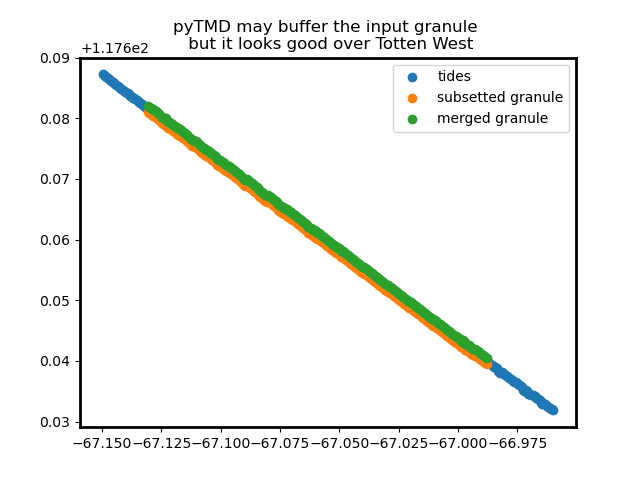

In [249]:
plt.figure()
plt.scatter(dst.latitude[()], dst.longitude[()], label='tides')
plt.scatter(ds.latitude[()], ds.longitude[()]-0.0005, label='subsetted granule')
plt.scatter(ds_merge.latitude[()], ds_merge.longitude[()]+0.0005, label='merged granule')
plt.title('pyTMD may buffer the input granule \n but it looks good over Totten West')
plt.legend()
#plt.colorbar()

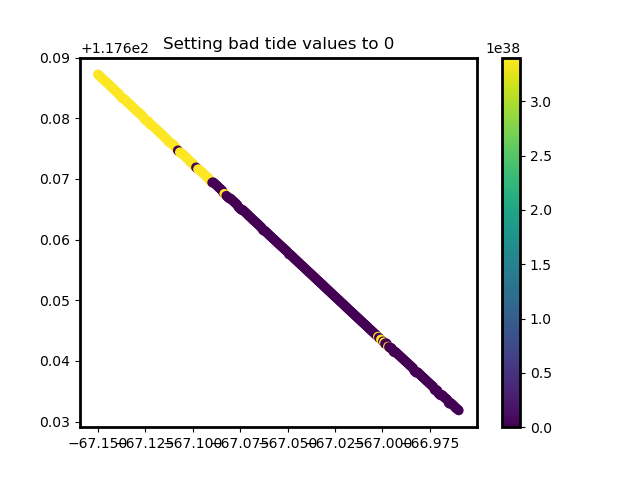

In [244]:
plt.figure()
plt.scatter(dst.latitude[()], dst.longitude[()], c=dst.tide_cats.sel(cycle_number=3), label='tides')
#plt.scatter(ds.latitude[()], ds.longitude[()], s=0.7, label='subsetted granule')
plt.title('Setting bad tide values to 0')
#plt.legend()
plt.colorbar()

AttributeError: 'Dataset' object has no attribute 'tide_ocean'

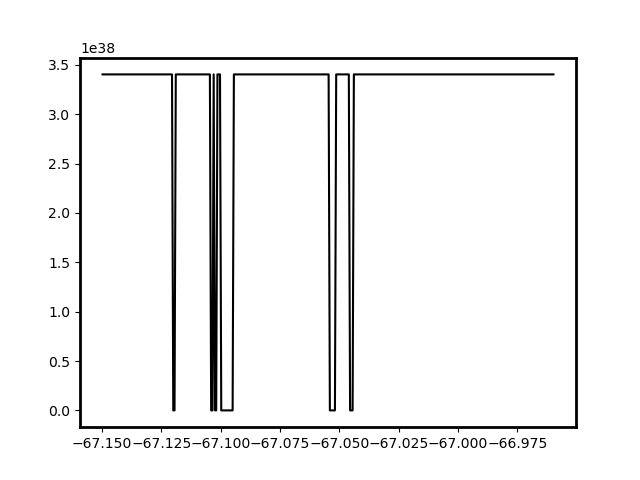

In [255]:
plt.figure()
plt.plot(dst.latitude, dst.tide_cats.sel(cycle_number=20), color='black')
plt.plot(dst.latitude, dst.tide_ocean.sel(cycle_number=20), color='red')
plt.ylim([-1, 1])

Text(0.5, 1.0, 'CATS2008_v2023 needs to be masked over pinning points')

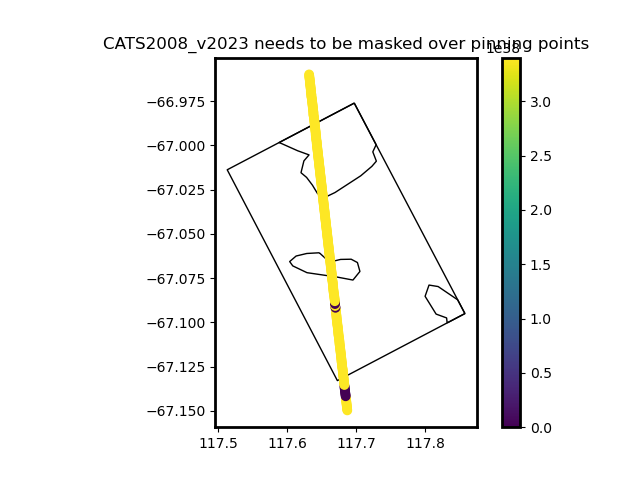

In [237]:
fig1, ax1 = plt.subplots()
pp_gdf.to_crs('EPSG:4326').plot(ax=ax1, color='None', edgecolor='black')
gdf.to_crs('EPSG:4326').plot(ax=ax1, color='None', edgecolor='black')
plt.scatter(dst.longitude[()], dst.latitude[()], c=dst.tide_cats.sel(cycle_number=5), label='tides')
plt.colorbar()
plt.title('CATS2008_v2023 needs to be masked over pinning points')

CPU times: user 6.37 s, sys: 662 ms, total: 7.03 s
Wall time: 7.53 s


/var/folders/_l/6jgyk_ms6jb13hn0khtb7f7m003707/T/ipykernel_98763/3317971099.py:205: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles=hdls, loc='lower right', fontsize=11)


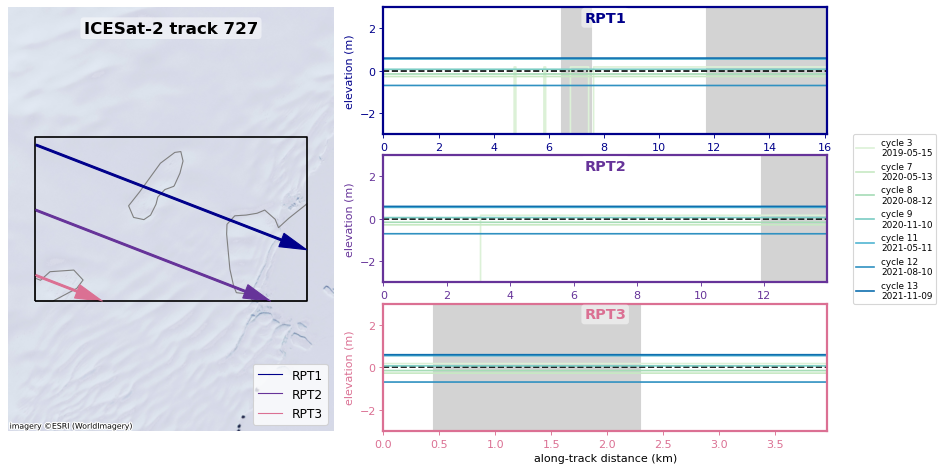

CPU times: user 979 ms, sys: 46.3 ms, total: 1.03 s
Wall time: 1.03 s


In [261]:
%%time
display(fig)

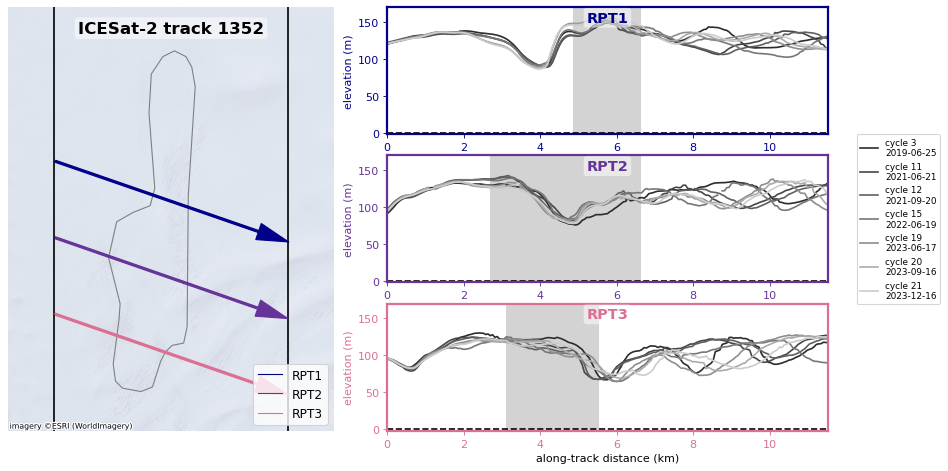

CPU times: user 808 ms, sys: 58.9 ms, total: 867 ms
Wall time: 881 ms


In [274]:
%%time
display(fig)

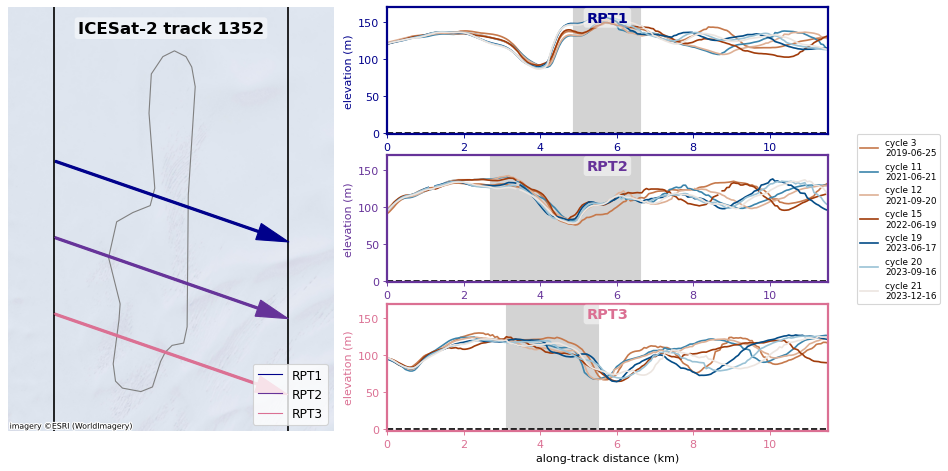

CPU times: user 777 ms, sys: 31.4 ms, total: 809 ms
Wall time: 816 ms


In [232]:
%%time
display(fig)

CPU times: user 675 ms, sys: 104 ms, total: 779 ms
Wall time: 794 ms


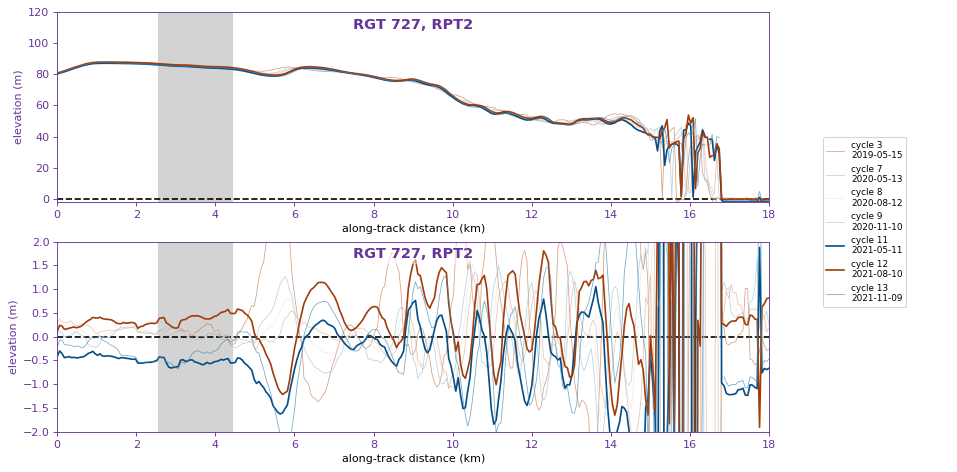

In [98]:
%%time
rpt = 2
plot_one(track, rpt, save=True)

In [34]:
####################################################################################################################################

In [270]:
##### test zone ###

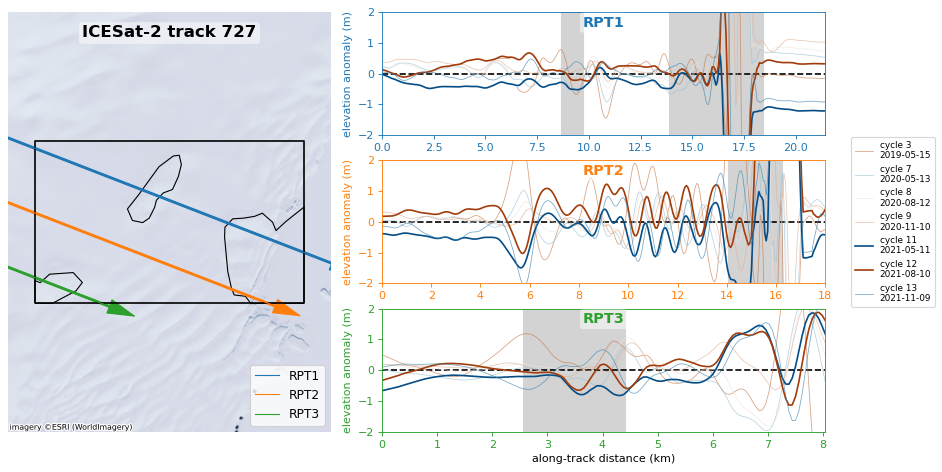

CPU times: user 1.03 s, sys: 58.3 ms, total: 1.09 s
Wall time: 1.1 s


In [290]:
%%time
display(fig)

In [280]:
pp_dist = get_grounded_distances(gdf_gts.geometry[1], pp_gdf)

In [281]:
pp_dist

[(8626.488960286888, 9690.461968682164),
 (13857.807437092688, 18431.95869034428)]

"\nintersection = gpd.GeoDataFrame([{'geometry': gdf_gts.iloc[1].geometry.intersection(pp_gdf.geometry[0])}], geometry='geometry')\nintersection.plot(ax=ax1, color='red')\n\ngreylim = [(l.coords[0], l.coords[-1]) for l in list(shapely.get_parts(intersection.geometry[0]))]\npt_back = gdf_gts.iloc[1].geometry.line_interpolate_point(gdf_gts.iloc[1].geometry.line_locate_point(Point(greylim[0][0])))\n\nax1.scatter(pt_back.x, pt_back.y, color='black')\n"

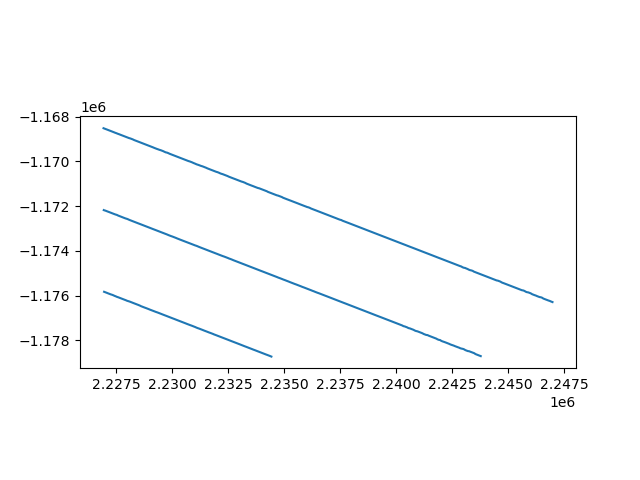

In [341]:
fig1, ax1 = plt.subplots()
gdf_gts.geometry.plot(ax=ax1)
pp_gdf.geometry.plot(ax=ax1)

'''
intersection = gpd.GeoDataFrame([{'geometry': gdf_gts.iloc[1].geometry.intersection(pp_gdf.geometry[0])}], geometry='geometry')
intersection.plot(ax=ax1, color='red')

greylim = [(l.coords[0], l.coords[-1]) for l in list(shapely.get_parts(intersection.geometry[0]))]
pt_back = gdf_gts.iloc[1].geometry.line_interpolate_point(gdf_gts.iloc[1].geometry.line_locate_point(Point(greylim[0][0])))

ax1.scatter(pt_back.x, pt_back.y, color='black')
'''

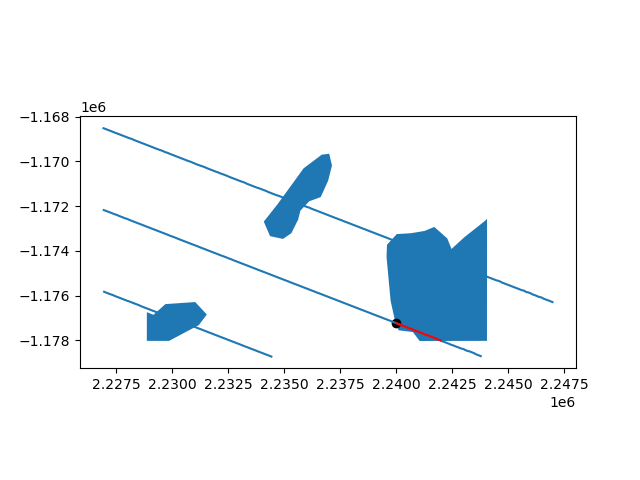

In [275]:
fig1, ax1 = plt.subplots()
gdf_gts.geometry.plot(ax=ax1)
pp_gdf.geometry.plot(ax=ax1)

intersection = gpd.GeoDataFrame([{'geometry': gdf_gts.iloc[1].geometry.intersection(pp_gdf.geometry[0])}], geometry='geometry')
intersection.plot(ax=ax1, color='red')

greylim = [(l.coords[0], l.coords[-1]) for l in list(shapely.get_parts(intersection.geometry[0]))]
pt_back = gdf_gts.iloc[1].geometry.line_interpolate_point(gdf_gts.iloc[1].geometry.line_locate_point(Point(greylim[0][0])))
ax1.scatter(pt_back.x, pt_back.y, color='black')

In [81]:
filename = df_files[df_files.track == track].filename.iloc[0]
datadict = read_atl11(filename)
gdf_gts = get_ground_tracks(datadict).to_crs(crs_antarctica)
#pp_gdf = pp_gdf
dfh_all = get_info_df_atl11(datadict)


In [251]:
gt_geom = gdf_gts.geometry[0]
pp_poly = pp_gdf.geometry[0]

# Get list of line strings over pinning points
pp_linestring = list(shapely.get_parts(gt_geom.intersection(pp_poly)))
pp_dist = [(gt_geom.line_locate_point(Point(l.coords[0])), gt_geom.line_locate_point(Point(l.coords[-1]))) for l in pp_linestring]

In [255]:
pp_dist

[(8626.488960286888, 9690.461968682164),
 (13857.807437092688, 18431.95869034428)]

In [ ]:
def get_grounded_pts(gt_geom, pp_poly):
    # Find where gt is grounded and return limits of each segment
    # to serve as limits for ax.axvspan()

    gt_geom = gdf_gts.geometry[0]
    pp_poly = pp_gdf.geometry[0]
    
    # Get list of line strings over pinning points
    pp_linestring = list(shapely.get_parts(gt_geom.intersection(pp_poly)))
    # grab the two alongtrack distance points 
    pp_dist = [(gt_geom.line_locate_point(Point(l.coords[0])), gt_geom.line_locate_point(Point(l.coords[-1]))) for l in pp_linestring]

    return pp_pts

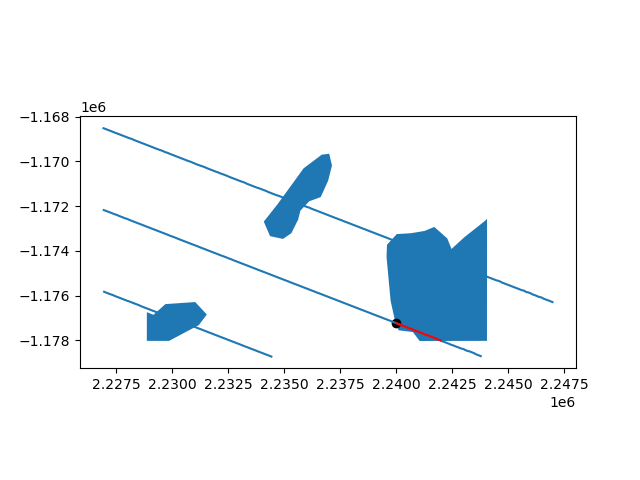

In [221]:
fig1, ax1 = plt.subplots()
gdf_gts.geometry.plot(ax=ax1)
pp_gdf.geometry.plot(ax=ax1)

intersection = gpd.GeoDataFrame([{'geometry': gdf_gts.iloc[1].geometry.intersection(pp_gdf.geometry[0])}], geometry='geometry')
intersection.plot(ax=ax1, color='red')

greylim = [(l.coords[0], l.coords[-1]) for l in list(shapely.get_parts(intersection.geometry[0]))]
pt_back = gdf_gts.iloc[1].geometry.line_interpolate_point(gdf_gts.iloc[1].geometry.line_locate_point(Point(greylim[0][0])))
ax1.scatter(pt_back.x, pt_back.y, color='black')

In [200]:
ds.x_atc

<xarray.DataArray 'x_atc' (x_atc: 358)> Size: 3kB
array([    0,    60,   120, ..., 21300, 21360, 21420])
Coordinates:
  * x_atc    (x_atc) int64 3kB 0 60 120 180 240 ... 21240 21300 21360 21420

In [160]:
firstlast = [(l.coords[0], l.coords[-1]) for l in list(shapely.get_parts(intersection.geometry[0]))]

In [161]:
firstlast

[((2234920.064268391, -1171613.1922815342),
  (2235910.5006768275, -1172000.8793127094)),
 ((2239796.1811106754, -1173501.1031391239),
  (2244055.3188532903, -1175155.473123985))]

In [143]:
x = [c[0] for c in firstlast[0].coords[:]]
y = [c[1] for c in firstlast[0].coords[:]]

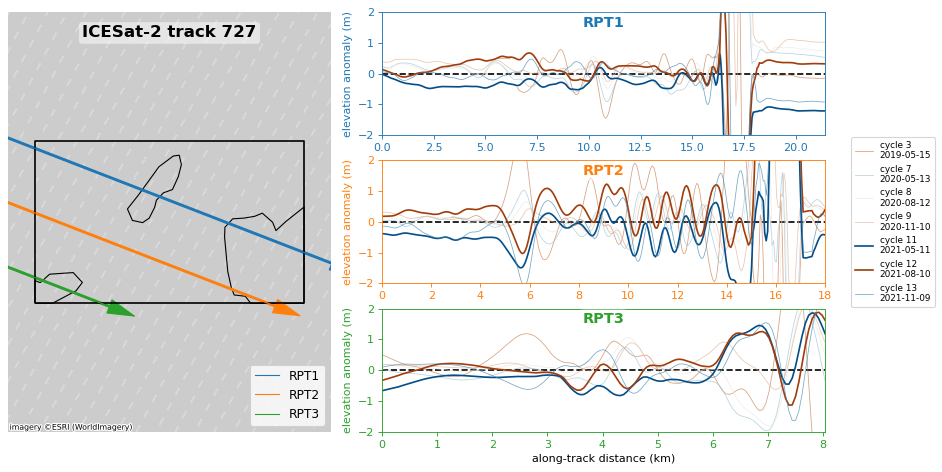

In [266]:
display(fig)

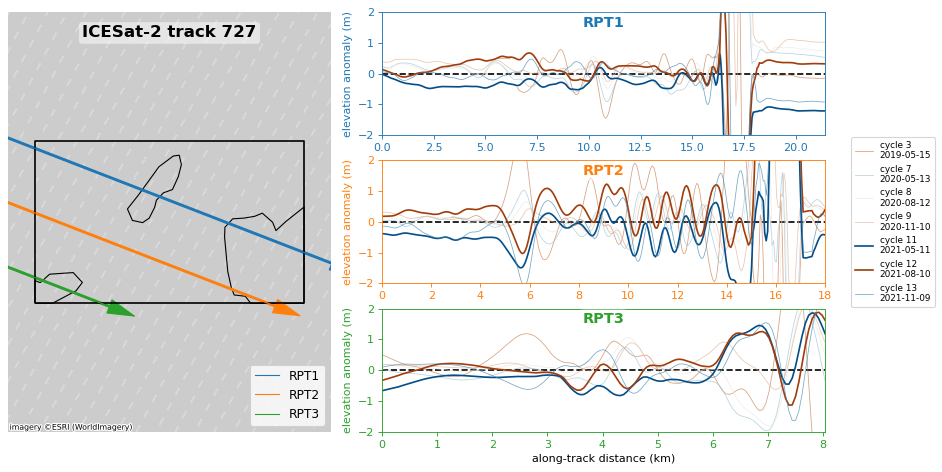

In [45]:
display(fig)

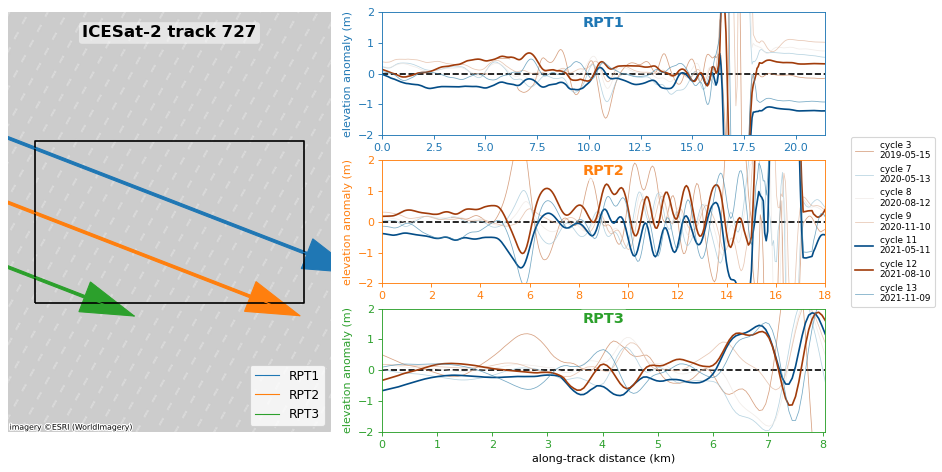

In [13]:
display(fig)

In [48]:
pp_gdf[0]

KeyError: 0

TypeError: cannot unpack non-iterable Figure object

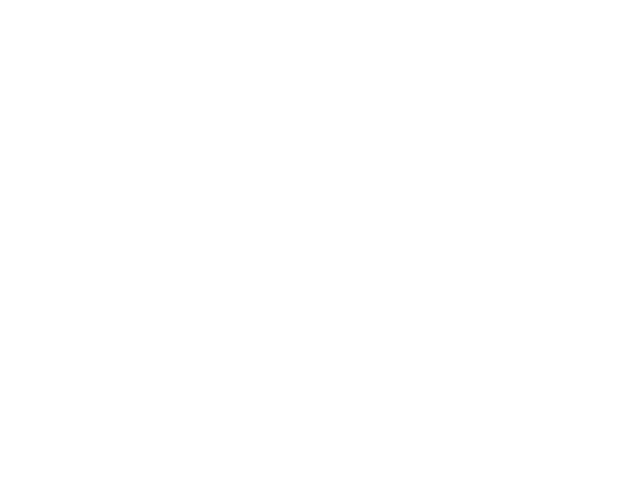

In [46]:
fig1, ax1 = plt.figure()
pp_gdf.plot(ax1=ax1)

In [30]:
shape_gdf.plot(ax=ax)

NameError: name 'ax' is not defined

In [29]:
help(gdf.plot)

Help on GeoplotAccessor in module geopandas.plotting object:

class GeoplotAccessor(pandas.plotting._core.PlotAccessor)
 |  GeoplotAccessor(data: 'Series | DataFrame') -> 'None'
 |
 |  Plot a GeoDataFrame.
 |
 |  Generate a plot of a GeoDataFrame with matplotlib.  If a
 |  column is specified, the plot coloring will be based on values
 |  in that column.
 |
 |  Parameters
 |  ----------
 |  column : str, np.array, pd.Series (default None)
 |      The name of the dataframe column, np.array, or pd.Series to be plotted.
 |      If np.array or pd.Series are used then it must have same length as
 |      dataframe. Values are used to color the plot. Ignored if `color` is
 |      also set.
 |  kind: str
 |      The kind of plots to produce. The default is to create a map ("geo").
 |      Other supported kinds of plots from pandas:
 |
 |      - 'line' : line plot
 |      - 'bar' : vertical bar plot
 |      - 'barh' : horizontal bar plot
 |      - 'hist' : histogram
 |      - 'box' : BoxPlot
 |

In [ ]:
# set imagery_resolution_adjust=-1 for quick plot making
# set imagery_resolution_adjust=2 for good imagery quality

for track in df_files.track:
    try:
        fig = make_plot(track, imagery_resolution_adjust=3)
        display(fig)
    except:
        # traceback.print_exc()
        pass